### Q2: How could you determine how many more stations to add along the water?

We can frame this as a capacity planning question by comparing supply to demand. The analysis ***compares the share of stations located within a waterfront buffer (e.g., 300m from water) to the share of trips that either start or end in the same area***.

If waterfront-related trips account for a greater proportion of system usage than waterfront stations represent of total system capacity, this indicates the waterfront is under-served relative to demand. ***The gap between these two proportions provides a quantitative estimate of the capacity shortfall***.This approach uses revealed demand (actual trips taken) as the baseline, which ***may underestimate true demand if potential users were deterred by bike shortages or full docking stations*** at waterfront locations. However, the demonstrated demand patterns provide a conservative foundation for capacity planning decisions.

#### Load libraries and data

In [1]:
import pandas as pd
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [2]:
# Load the CSV with stations already matched to NTAs
station_to_nta = pd.read_csv(r"C:\Users\magia\OneDrive\Desktop\NY_Citi_Bike\2.Data\Prepared Data\station_to_nta.csv")

# Convert to GeoDataFrame
stations = gpd.GeoDataFrame(
    station_to_nta,
    geometry=gpd.points_from_xy(station_to_nta.lng, station_to_nta.lat),
    crs="EPSG:4326"
)

In [3]:
station_to_nta.head()

,Unnamed: 0,station_name,lat,lng,nta_code,nta_name,borough
0,0,1 Ave & E 110 St,40.792328,-73.938300,MN1102,East Harlem (North),Manhattan
1,1,1 Ave & E 110 St,40.792480,-73.938190,MN1102,East Harlem (North),Manhattan
2,2,1 Ave & E 110 St,40.792427,-73.938390,MN1102,East Harlem (North),Manhattan
3,3,1 Ave & E 110 St,40.792152,-73.937744,MN1101,East Harlem (South),Manhattan
4,4,1 Ave & E 110 St,40.792347,-73.937870,MN1101,East Harlem (South),Manhattan


#### Pull geographic data on water bodies in NYC

In [4]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module=r"osmnx\.features")

In [5]:
METRIC = "EPSG:26918"  # meters (UTM 18N)

# --- NYC polygon
nyc_4326 = ox.geocode_to_gdf("New York City, New York, USA").to_crs(4326)
poly_4326 = nyc_4326.geometry.iloc[0]
nyc_m = nyc_4326.to_crs(METRIC)
nyc_poly_m = nyc_m.geometry.iloc[0]

def safe_features_m(poly_4326, tags):
    try:
        g = ox.features_from_polygon(poly_4326, tags)
        if g.empty:
            return gpd.GeoDataFrame(geometry=[], crs=METRIC)
        return g.to_crs(METRIC)
    except Exception:
        return gpd.GeoDataFrame(geometry=[], crs=METRIC)

# --- Fetch only what’s reliable: water polygons + coastline
water_poly_m = safe_features_m(poly_4326, {"natural": "water"})
coastline_m  = safe_features_m(poly_4326, {"natural": "coastline"})

# --- Keep big/tidal features; drop tiny ponds
keep_types = {"river","sea","bay","harbour","estuary","tidal_channel"}
if not water_poly_m.empty:
    water_poly_m["area_m2"] = water_poly_m.geometry.area
    wtype = water_poly_m.get("water").fillna("")
    mask_type = wtype.isin(keep_types)
    mask_area = water_poly_m["area_m2"] >= 1e5  # ≥ 0.1 km²
    water_big = water_poly_m[mask_type | mask_area][["geometry"]].copy()
else:
    water_big = gpd.GeoDataFrame(geometry=[], crs=METRIC)

layers = []
if not water_big.empty:
    layers.append(water_big)
if not coastline_m.empty:
    coast = coastline_m.copy()
    coast["geometry"] = coast.buffer(10)  # 10 m ribbon so coastline behaves like a polygon
    layers.append(coast[["geometry"]])

if not layers:
    raise RuntimeError("No suitable water features returned from OSM.")

water_m_filt = pd.concat(layers, ignore_index=True)
water_union  = water_m_filt.union_all()  # Shapely 2.x

# --- Land-side 300 m ribbon
land = nyc_poly_m.difference(water_union.buffer(1))       # land mask (avoid slivers)
ribbon_land = water_union.buffer(300).intersection(land)  # keep land-side only

# --- Sanity check
area_km2 = gpd.GeoSeries([ribbon_land], crs=METRIC).area.iloc[0] / 1e6
L_km = area_km2 / 0.3
print(f"Land-side ribbon area (km²): {area_km2:,.1f}")
print(f"Implied shoreline length (km): {L_km:,.0f}")

Land-side ribbon area (km²): 256.9
Implied shoreline length (km): 856


#### Define waterfront stations

In [6]:
# 1) normalize names to avoid whitespace/case dupes
s = stations.copy()
s["station_key"] = s["station_name"].str.strip().str.lower()

# helper to pick the most common value
def _mode(x):
    m = x.mode()
    return m.iloc[0] if not m.empty else x.iloc[0]

# 2) collapse duplicates by name; use median coords
unique = (s.groupby("station_key", as_index=False)
           .agg(station_name=("station_name","first"),
                lat=("lat","median"),
                lng=("lng","median"),
                borough=("borough", _mode),
                nta_name=("nta_name", _mode),
                nta_code=("nta_code", _mode)))

# 3) back to GeoDataFrame
stations_u = gpd.GeoDataFrame(
    unique,
    geometry=gpd.points_from_xy(unique["lng"], unique["lat"]),
    crs="EPSG:4326"
)

stations_u.head()

,station_key,station_name,lat,lng,borough,nta_name,nta_code,geometry
0,1 ave & e 110 st,1 Ave & E 110 St,40.792380,-73.938160,Manhattan,East Harlem (North),MN1102,POINT (-73.938 40.792)
1,1 ave & e 16 st,1 Ave & E 16 St,40.732246,-73.981670,Manhattan,Stuyvesant Town-Peter Cooper Village,MN0601,POINT (-73.982 40.732)
2,1 ave & e 18 st,1 Ave & E 18 St,40.734062,-73.980415,Manhattan,Stuyvesant Town-Peter Cooper Village,MN0601,POINT (-73.98 40.734)
3,1 ave & e 30 st,1 Ave & E 30 St,40.741547,-73.975300,Manhattan,Murray Hill-Kips Bay,MN0603,POINT (-73.975 40.742)
4,1 ave & e 39 st,1 Ave & E 39 St,40.747300,-73.971040,Manhattan,Murray Hill-Kips Bay,MN0603,POINT (-73.971 40.747)


#### Calculate station ratio

In [7]:
# Tag stations within the 300 m land-side ribbon and compute supply share
METRIC = "EPSG:26918"  # meters

stations_m = stations_u.to_crs(METRIC).copy()
stations_m["near_water"] = stations_m.within(ribbon_land)  # use .intersects(...) if you want boundary-inclusive

stations_flagged = stations_m.to_crs(4326).drop(columns="geometry")
print("Supply share (stations near water):", round(stations_flagged["near_water"].mean(), 3))
print(stations_flagged["near_water"].value_counts())

Supply share (stations near water): 0.148
False    1569
True      273
Name: near_water, dtype: int64


#### Calculate trip ratio (only starts)

In [8]:
# 1) Lookup: station_name -> near_water
flags = stations_flagged[["station_name","near_water"]].copy()
flags["station_key"] = flags["station_name"].str.strip().str.lower()
flags = flags.drop_duplicates(subset="station_key")[["station_key","near_water"]]

# 2) Tag each trip-start row as waterfront or not
t = station_to_nta.copy()
t["station_key"] = t["station_name"].astype(str).str.strip().str.lower()
t = t.merge(flags, on="station_key", how="left")

# check match rate
matched = t["near_water"].notna().mean()
print(f"Matched starts to stations: {matched:.1%}")

# 3) Demand share (starts-only), compare to supply, and estimate shortfall
demand_share = t["near_water"].fillna(False).mean()  # treat unmatched as non-waterfront
supply_share = stations_flagged["near_water"].mean()
total_stations = len(stations_flagged)
missing_stations = max(0, int(round((demand_share - supply_share) * total_stations)))

print(f"Demand share (starts near waterfront): {demand_share:.3f}")
print(f"Supply share (stations on waterfront): {supply_share:.3f}")
print(f"Implied station shortfall: {missing_stations}")

Matched starts to stations: 100.0%
Demand share (starts near waterfront): 0.124
Supply share (stations on waterfront): 0.148
Implied station shortfall: 0


#### Loading our 2022 NYC file that has all trips (both starts and ends)

In [9]:
import os

TRIPS_PATH = r"C:\Users\magia\OneDrive\Desktop\NY_Citi_Bike\2.Data\Prepared Data\nyc_2022_essential_data.csv" 

assert isinstance(TRIPS_PATH, (str, os.PathLike)) and os.path.exists(TRIPS_PATH), "TRIPS_PATH must be a valid file path."

# 3) Build lookup once
flags = stations_flagged[["station_name","near_water"]].copy()
flags["station_key"] = flags["station_name"].astype(str).str.strip().str.lower()
flag_map = dict(zip(flags["station_key"], flags["near_water"]))

supply_share   = stations_flagged["near_water"].mean()
total_stations = len(stations_flagged)

# 4) Stream + compute demand share (start OR end near water)
touches = 0
total   = 0
CHUNK   = 500_000

usecols = ["start_station_name","end_station_name"]
dtype   = {"start_station_name":"string","end_station_name":"string"}

for chunk in pd.read_csv(TRIPS_PATH, usecols=usecols, dtype=dtype, chunksize=CHUNK, low_memory=False):
    s = chunk["start_station_name"].str.strip().str.lower()
    e = chunk["end_station_name"].str.strip().str.lower()
    start_flag = s.map(flag_map).fillna(False)
    end_flag   = e.map(flag_map).fillna(False)
    touches += int((start_flag | end_flag).sum())
    total   += len(chunk)

demand_share = touches / total if total else 0.0
missing_stations = max(0, int(round((demand_share - supply_share) * total_stations)))

print(f"Rows processed: {total:,}")
print(f"Demand share (start OR end near waterfront): {demand_share:.3f}")
print(f"Supply share (stations on waterfront):       {supply_share:.3f}")
print(f"Implied station shortfall:                    {missing_stations}")

Rows processed: 29,838,166
Demand share (start OR end near waterfront): 0.243
Supply share (stations on waterfront):       0.148
Implied station shortfall:                    175


- So we have ~15% share of the physical infrastucture be waterfront-close, and ~24% of usage share be waterfront-related (whether as a start or end point). So waterfront stations are already generating about 64% more trips per station than the system average (24.3% ÷ 14.8% = 1.64x).
- This translates  to roughly 175 stations on the waterfront (if we reallocate) and 230 new stations if we go for expanding the number of total NYC stations.
- This whopping numbers give us opportunity to pause and check if the approach we chose is right to begin with.

#### The Pitfall: Mixing Apples and Oranges (or Conflating Endpoints with Trips)
We realize a fundamental flaw in our initial approach. The 24.3% "waterfront demand" includes three types of trips:

- a) Pure waterfront trips: Both start AND end at waterfront stations (4.1%)
- b) Mixed trips: One end waterfront, one end inland (20.2%)
- c) Pure inland trips: Neither end waterfront (75.7%)
  
The critical issue: ***Mixed trips use both waterfront AND inland infrastructure, yet the original method attributed 100% of their demand to "waterfront need".***

Consider a trip from Brooklyn Heights (waterfront) to Midtown (inland). This trip:
- Counts toward the 24.3% "waterfront demand"
- But actually it requires 50% waterfront capacity and 50% inland capacity
- The calculation incorrectly assumed we'd need pure waterfront stations to serve this demand

This ***double-counting inflated the apparent need for waterfront stations***.

***Refined Approach: Apples-to-Apples Comparison***

The solution is to measure ***what fraction of all trip endpoints occur at waterfront stations***, creating a direct comparison with the fraction of stations that are waterfront.

***Methodology***

Instead of counting trips that "touch" waterfront (OR logic), we now ***count individual endpoints***:
- Each trip generates 2 endpoints (1 start + 1 end)
- Count how many endpoints occur at waterfront stations
- Calculate: (waterfront endpoints) / (total endpoints)

In [10]:
CHUNK = 500_000
usecols = ["start_station_name","end_station_name"]
dtype   = {"start_station_name":"string","end_station_name":"string"}

total = 0
endpoints_water = 0  # counts waterfront endpoints (start + end)

for chunk in pd.read_csv(TRIPS_PATH, usecols=usecols, dtype=dtype, chunksize=CHUNK, low_memory=False):
    s = chunk["start_station_name"].str.strip().str.lower().map(flag_map).fillna(False)
    e = chunk["end_station_name"].str.strip().str.lower().map(flag_map).fillna(False)
    endpoints_water += int(s.sum() + e.sum())
    total += len(chunk)

d_endpoints = endpoints_water / (2 * total) if total else 0.0
shortfall_reallocate = max(0, int(round((d_endpoints - supply_share) * total_stations)))

print(f"Rows processed: {total:,}")
print(f"Endpoint share (fraction of all endpoints near water): {d_endpoints:.3f}")
print(f"Supply share (stations on waterfront):                 {supply_share:.3f}")
print(f"Implied station shortfall (reallocate existing):       {shortfall_reallocate}")

Rows processed: 29,838,166
Endpoint share (fraction of all endpoints near water): 0.142
Supply share (stations on waterfront):                 0.148
Implied station shortfall (reallocate existing):       0


#### Endpoint distribution among waterfront stations

In [11]:
import numpy as np
from collections import Counter

# --- lookups ---
f = stations_flagged[["station_name","near_water"]].copy()
f["station_key"] = f["station_name"].astype(str).str.strip().str.lower()
water_keys = set(f.loc[f["near_water"], "station_key"])

meta = stations_u.copy()
meta["station_key"] = meta["station_name"].astype(str).str.strip().str.lower()
meta = meta.drop_duplicates("station_key")[["station_key","station_name","borough","lat","lng"]]

# --- stream & count endpoints at waterfront stations ---
counts = Counter()
CHUNK = 500_000
usecols = ["start_station_name","end_station_name"]
dtype   = {"start_station_name":"string","end_station_name":"string"}

for chunk in pd.read_csv(TRIPS_PATH, usecols=usecols, dtype=dtype, chunksize=CHUNK, low_memory=False):
    s = chunk["start_station_name"].str.strip().str.lower()
    e = chunk["end_station_name"].str.strip().str.lower()
    counts.update(s[s.isin(water_keys)].value_counts().to_dict())
    counts.update(e[e.isin(water_keys)].value_counts().to_dict())

wf_counts = pd.DataFrame({"station_key": list(counts.keys()), "endpoints": list(counts.values())})
wf_counts = wf_counts.merge(meta, on="station_key", how="left").sort_values("endpoints", ascending=False)
wf_counts["share_of_water_endpoints"] = wf_counts["endpoints"] / wf_counts["endpoints"].sum()

# --- quick distribution stats ---
q = wf_counts["endpoints"].quantile([0.5,0.75,0.9,0.95,0.99]).round(0).astype(int)
n = len(wf_counts); x = np.sort(wf_counts["endpoints"].values.astype(float)); 
gini = (2*np.sum((np.arange(1, n+1) * x)))/(n*x.sum()) - (n+1)/n

print(f"Waterfront stations counted: {len(wf_counts)}")
print(f"Total waterfront endpoints:  {int(wf_counts['endpoints'].sum()):,}")
print("Percentiles (endpoints):", q.to_dict())
print(f"Gini (endpoint concentration across waterfront stations): {gini:.2f}")

# peek: top/bottom stations
display(wf_counts.head(20)[["station_name","borough","endpoints","share_of_water_endpoints"]])
display(wf_counts.tail(20)[["station_name","borough","endpoints","share_of_water_endpoints"]])

Waterfront stations counted: 273
Total waterfront endpoints:  8,452,183
Percentiles (endpoints): {0.5: 16860, 0.75: 42906, 0.9: 82467, 0.95: 113757, 0.99: 156255}
Gini (endpoint concentration across waterfront stations): 0.58


,station_name,borough,endpoints,share_of_water_endpoints
1,West St & Chambers St,Manhattan,247625,0.029297
0,E 33 St & 1 Ave,Manhattan,181674,0.021494
2,West St & Liberty St,Manhattan,175364,0.020748
47,10 Ave & W 14 St,Manhattan,148824,0.017608
3,Wythe Ave & Metropolitan Ave,Brooklyn,133592,0.015806
9,Washington St & Gansevoort St,Manhattan,131235,0.015527
15,Pier 40 - Hudson River Park,Manhattan,129231,0.015290
17,Vesey Pl & River Terrace,Manhattan,126607,0.014979
4,W 44 St & 11 Ave,Manhattan,126360,0.014950
6,Kent Ave & N 7 St,Brooklyn,121713,0.014400


,station_name,borough,endpoints,share_of_water_endpoints
117,Vernon Blvd & 30 Rd,Queens,1159,1.371243e-04
246,Pier 40 Dock Station,Manhattan,1139,1.347581e-04
233,West Farms Rd & Boone Ave,Bronx,1073,1.269495e-04
243,Sedgwick Ave & Hall of Fame Tce,Bronx,775,9.169229e-05
224,9 Ave & W 206 St,Manhattan,760,8.991760e-05
203,57 St & 1 Ave - Brooklyn Army Terminal Vaccina...,Brooklyn,757,8.956266e-05
271,Vernon Blvd & Queens Plaza S,Queens,756,8.944435e-05
242,9 Ave & W 219 St,Manhattan,562,6.649170e-05
272,E 85 St & East End Ave,Manhattan,538,6.365219e-05
190,20 Ave & 33 St,Queens,532,6.294232e-05


### Top waterfront hotspot and time-concentration metrics for these

In [12]:
# 1) How dominant are top nodes? and 2) concrete hospot list for siting focus

wf = wf_counts.sort_values("endpoints", ascending=False).reset_index(drop=True)
wf["cum_share"] = wf["share_of_water_endpoints"].cumsum()

top10_share      = wf["share_of_water_endpoints"].head(10).sum()
top10pct_n       = max(1, int(round(0.10 * len(wf))))
top10pct_share   = wf["share_of_water_endpoints"].head(top10pct_n).sum()
bottom50pct_n    = int(round(0.50 * len(wf)))
bottom50pct_share= wf["share_of_water_endpoints"].tail(bottom50pct_n).sum()

hotspots = wf.loc[wf["cum_share"] <= 0.50, ["station_name","borough","endpoints","share_of_water_endpoints","cum_share"]]

print(f"Top 10 stations share of waterfront endpoints: {top10_share:.2%}")
print(f"Top 10% stations ({top10pct_n}) share:         {top10pct_share:.2%}")
print(f"Bottom 50% stations share:                     {bottom50pct_share:.2%}")
print(f"Hotspot count (to reach 50% of endpoints):     {len(hotspots)}")

hotspots.head(20)

Top 10 stations share of waterfront endpoints: 18.01%
Top 10% stations (27) share:         38.83%
Bottom 50% stations share:                     10.11%
Hotspot count (to reach 50% of endpoints):     40


,station_name,borough,endpoints,share_of_water_endpoints,cum_share
0,West St & Chambers St,Manhattan,247625,0.029297,0.029297
1,E 33 St & 1 Ave,Manhattan,181674,0.021494,0.050791
2,West St & Liberty St,Manhattan,175364,0.020748,0.071539
3,10 Ave & W 14 St,Manhattan,148824,0.017608,0.089147
4,Wythe Ave & Metropolitan Ave,Brooklyn,133592,0.015806,0.104953
5,Washington St & Gansevoort St,Manhattan,131235,0.015527,0.120479
6,Pier 40 - Hudson River Park,Manhattan,129231,0.015290,0.135769
7,Vesey Pl & River Terrace,Manhattan,126607,0.014979,0.150748
8,W 44 St & 11 Ave,Manhattan,126360,0.014950,0.165698
9,Kent Ave & N 7 St,Brooklyn,121713,0.014400,0.180098


These numbers show ***great concentration***:

- Top 10 stations = 18% of waterfront endpoints.
- Top 10% (27 stations) = 38.8%
- ***Just 40 out of the 273 stations deliver 50% of all waterfront endpoints***.
- Gini 0.58 ⇒ demand is very uneven across waterfront stations.

But concentration alone doesn’t prove we need new stations. If those stations’ trips are spread across the day, ops can usually cope without extra hardware. ***If, however, a large share clusters in a few hours*** (e.g., peak_hour ≳ 12% or top-3 hours ≳ 30% with span50 ≤ 6), ***then adding small satellites nearby can reasonably target latent demand that was previously constrained by full/empty conditions***.

In [13]:
# add a hotspot index per station

baseline = 1 / len(wf_counts)  # equal share if demand were uniform
wf_counts["hotspot_index"] = wf_counts["share_of_water_endpoints"] / baseline
wf_counts.sort_values("hotspot_index", ascending=False).head(20)[
    ["station_name","borough","endpoints","share_of_water_endpoints","hotspot_index"]
]

,station_name,borough,endpoints,share_of_water_endpoints,hotspot_index
1,West St & Chambers St,Manhattan,247625,0.029297,7.998126
0,E 33 St & 1 Ave,Manhattan,181674,0.021494,5.867952
2,West St & Liberty St,Manhattan,175364,0.020748,5.664143
47,10 Ave & W 14 St,Manhattan,148824,0.017608,4.806918
3,Wythe Ave & Metropolitan Ave,Brooklyn,133592,0.015806,4.314934
9,Washington St & Gansevoort St,Manhattan,131235,0.015527,4.238805
15,Pier 40 - Hudson River Park,Manhattan,129231,0.015290,4.174077
17,Vesey Pl & River Terrace,Manhattan,126607,0.014979,4.089324
4,W 44 St & 11 Ave,Manhattan,126360,0.014950,4.081346
6,Kent Ave & N 7 St,Brooklyn,121713,0.014400,3.931251


In [14]:
# Trips per hotspot station by hour-of_day

from collections import defaultdict

hs = hotspots.copy()
hs["station_key"] = hs["station_name"].astype(str).str.strip().str.lower()
hotspot_keys = set(hs["station_key"])
key_to_name   = dict(zip(hs["station_key"], hs["station_name"]))

# 24-hour counters per hotspot
hour_counts = {k: np.zeros(24, dtype=np.int64) for k in hotspot_keys}
trip_totals = defaultdict(int)

CHUNK = 500_000
usecols = ["start_station_name","end_station_name","started_at","ended_at"]
dtype   = {"start_station_name":"string","end_station_name":"string"}

for chunk in pd.read_csv(TRIPS_PATH, usecols=usecols, dtype=dtype, chunksize=CHUNK, low_memory=False):
    s_key = chunk["start_station_name"].str.strip().str.lower()
    e_key = chunk["end_station_name"].str.strip().str.lower()
    mask_hot = s_key.isin(hotspot_keys) | e_key.isin(hotspot_keys)
    if not mask_hot.any():
        continue

    sub   = chunk.loc[mask_hot]
    s_key = s_key[mask_hot]; e_key = e_key[mask_hot]
    s_hr  = pd.to_datetime(sub["started_at"], errors="coerce").dt.hour
    e_hr  = pd.to_datetime(sub["ended_at"],   errors="coerce").dt.hour

    involved = pd.Index(s_key[s_key.isin(hotspot_keys)].unique()).union(
               pd.Index(e_key[e_key.isin(hotspot_keys)].unique()))
    for k in involved:
        ms = (s_key == k)
        me = (e_key == k) & (~ms)  # avoid double-counting round-trips to same station

        if ms.any():
            hour_counts[k] += np.bincount(s_hr[ms].dropna().astype(int), minlength=24)
        if me.any():
            hour_counts[k] += np.bincount(e_hr[me].dropna().astype(int), minlength=24)

        trip_totals[k] += int(ms.sum() + me.sum())

# Summaries per hotspot
rows = []
for k, counts in hour_counts.items():
    total = counts.sum()
    if total == 0:
        rows.append({"station_name": key_to_name.get(k,k), "total_trips": 0,
                     "peak_hour": None, "peak_share": np.nan,
                     "top3_share": np.nan, "span50_hours": np.nan, "hhi_norm": np.nan})
        continue
    p = counts / total
    peak_hour   = int(np.argmax(counts))
    peak_share  = float(counts.max() / total)
    top3_share  = float(np.sort(p)[-3:].sum())
    span50      = int((np.sort(p)[::-1].cumsum() <= 0.5).sum() + 1)
    hhi         = float((p**2).sum())
    hhi_norm    = (hhi - 1/24) / (1 - 1/24)  # 0=flat, 1=all in one hour
    rows.append({
        "station_name": key_to_name.get(k, k),
        "total_trips": int(total),
        "peak_hour": peak_hour,
        "peak_share": round(peak_share, 3),
        "top3_share": round(top3_share, 3),
        "span50_hours": span50,
        "hhi_norm": round(hhi_norm, 3),
    })

hotspot_hourly_summary = pd.DataFrame(rows).sort_values(["peak_share","total_trips"], ascending=[False,False])
hotspot_hourly_summary.head(20)

,station_name,total_trips,peak_hour,peak_share,top3_share,span50_hours,hhi_norm
15,North Moore St & Greenwich St,115933,17,0.148,0.358,5,0.035
26,Vesey Pl & River Terrace,124450,17,0.121,0.317,6,0.028
8,West St & Chambers St,242857,18,0.120,0.320,6,0.029
18,W 15 St & 10 Ave,69650,17,0.113,0.309,6,0.031
5,1 Ave & E 44 St,61150,9,0.109,0.312,6,0.027
39,5 Ave & E 87 St,107822,15,0.108,0.316,5,0.038
30,E 25 St & 1 Ave,74600,8,0.107,0.247,7,0.018
29,West St & Liberty St,172193,17,0.105,0.288,6,0.025
36,10 Ave & W 14 St,146098,17,0.105,0.305,6,0.031
22,11 Ave & W 27 St,114843,17,0.103,0.284,7,0.021


***Recap — time-concentration metrics for the 40 waterfront hotspots (~50% of all waterfront endpoints)***
1. ***Peak hour (which hour peaks?)*** Five distinct peak hours, heavily PM-skewed: ***17:00 (18 stations, 45%)***, ***18:00 (16, 40%)***, then ***08:00 (3)***, ***15:00 (2)***, ***09:00 (1)***.
2. ***span50*** (hours needed to reach 50% of a station's daily trips, taking hours from highest to lowest) Mostly ***5–7 hours*** → half the day's volume happens in about a quarter of the day.
3. ***peak_share*** (single busiest hour's share) We flag ***≥12%*** because with ~17 "active" hours, an even hour ≈ ***5.9%***; 12% is ~***2×*** even. Typical range is ***10–15%***, so a few stations are clearly above baseline.
4. ***top3_share*** (busiest three hours combined) We flag ***≥30%***. On an even 17-hour day, three hours ≈ ***17.6%***; 30% is approx.***1.7×*** even. Observed values are ***~27–36%***, with several at/above 30% (e.g., ***35.8%, 32.0%, 31.7%, 30.9%, 31.2%, 31.6%, 30.5%***).
5. ***HHI_norm*** (0 = flat across hours; 1 = all demand in one hour) Values are low (***~0.02–0.04***) → meaningful peaks, but not extreme.

#### Candidate stations

In [15]:
# Flag "capacity candidates"
crit = (
    (hotspot_hourly_summary["peak_share"] >= 0.12) |
    ((hotspot_hourly_summary["top3_share"] >= 0.30) & (hotspot_hourly_summary["span50_hours"] <= 6))
)
candidates = hotspot_hourly_summary.loc[crit].copy()
candidates["suggestion"] = np.where(
    candidates["peak_share"] >= 0.12, "consider docks nearby", "prioritize valet/flex ops at peak"
)
candidates.sort_values(["peak_share","top3_share","total_trips"], ascending=False).head(25)

,station_name,total_trips,peak_hour,peak_share,top3_share,span50_hours,hhi_norm,suggestion
15,North Moore St & Greenwich St,115933,17,0.148,0.358,5,0.035,consider docks nearby
26,Vesey Pl & River Terrace,124450,17,0.121,0.317,6,0.028,consider docks nearby
8,West St & Chambers St,242857,18,0.120,0.320,6,0.029,consider docks nearby
18,W 15 St & 10 Ave,69650,17,0.113,0.309,6,0.031,prioritize valet/flex ops at peak
5,1 Ave & E 44 St,61150,9,0.109,0.312,6,0.027,prioritize valet/flex ops at peak
39,5 Ave & E 87 St,107822,15,0.108,0.316,5,0.038,prioritize valet/flex ops at peak
36,10 Ave & W 14 St,146098,17,0.105,0.305,6,0.031,prioritize valet/flex ops at peak


 ***Our candidate rule*** is :  Flag if ***peak_share ≥ 12%*** ***OR*** (***top3_share ≥ 30%*** ***AND*** ***span50 ≤ 6***). Our reasoning for both top3 & span50 conditions is: A 2–3-hour wave is meaningful only if the whole day is also tight (half the day’s trips in ≤6 hours). Using AND prevents false positives like “busy-but-spread” stations that have 3 moderately high hours yet still operate across many hours—better handled with ops, not new hardware.
 
 ***Result (as above): 7 stations flagged as candidates.*** These are:
 1. North Moore St & Greenwich St
 2. Vesey Pl & River Terrace
 3. West St & Chambers St
 4. W 15 St & 10 Ave
 5. 1 Ave & E 44 St
 6. 5 Ave & E 87 St
 7. 10 Ave & W 14 St

#### Conclusion

With a ***300 m definition*** and station-count supply, ***no additional waterfront stations are needed system-wide*** (demand ≈ supply).

- System balance: Endpoint share (14.2%) ≈ station share (14.8%) → no system-wide waterfront shortfall.

- Hotspots: Peak-hour shares ~10–15% (vs ~5.9% for a 17-hour “active day” baseline) and span50 = 5–7 hours → ***peaks are real but not extreme***

- Concentration: 40 stations = ~50% of waterfront endpoints → focus efforts, don’t blanket-expand.

***Recommendation***: Start with targeted pilot of 3-7 stations near the identified most time-concentrated waterfront hotspots. 

### Visualizations

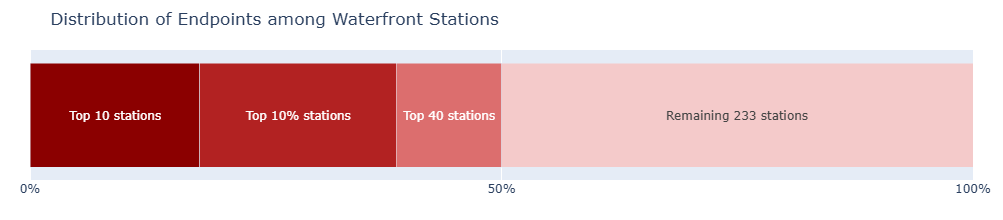

In [16]:
import plotly.graph_objects as go

# --- Build buckets from your dataframe ---
wf = wf_counts.sort_values("endpoints", ascending=False).reset_index(drop=True)
wf["cum_share"] = wf["share_of_water_endpoints"].cumsum()

total_stations   = len(wf)
top10_share      = wf["share_of_water_endpoints"].head(10).sum()
top10pct_n       = max(1, int(round(0.10 * total_stations)))
top10pct_share   = wf["share_of_water_endpoints"].head(top10pct_n).sum()
hotspots_n       = int((wf["cum_share"] <= 0.50).sum())  # e.g., 40

# Segment widths (sum to 1.0)
seg1 = top10_share                                      # Top 10
seg2 = max(0.0, top10pct_share - top10_share)           # to Top 10%
seg3 = max(0.0, 0.50 - top10pct_share)                  # to 50%
seg4 = 0.50                                             # remaining half

counts = {
    "seg1": 10,
    "seg2": max(0, top10pct_n - 10),
    "seg3": max(0, hotspots_n - top10pct_n),
    "seg4": max(0, total_stations - hotspots_n),
}

fig = go.Figure()

# Seg1 — label text on bar; hover shows only % share
fig.add_bar(
    name="Top 10 stations",
    x=[seg1], y=[""],
    orientation="h",
    marker_color="#8B0000",
    text=["Top 10 stations"], textposition="inside", insidetextanchor="middle",
    textfont_color="white",
    hovertemplate="Share: %{x:.1%}<extra></extra>"
)

# Seg2 — label text; hover shows added share
fig.add_bar(
    name="Top 10% stations",
    x=[seg2], y=[""],
    orientation="h",
    marker_color="#B22222",
    text=["Top 10% stations"], textposition="inside", insidetextanchor="middle",
    textfont_color="white",
    hovertemplate="Next " + str(counts['seg2']) + " stations<br>Added share: %{x:.1%}<extra></extra>"
)

# Seg3 — label text with concrete count (Top 40); hover shows added share
fig.add_bar(
    name=f"Top {hotspots_n} stations",
    x=[seg3], y=[""],
    orientation="h",
    marker_color="#DC6E6E",
    text=[f"Top {hotspots_n} stations"], textposition="inside", insidetextanchor="middle",
    textfont_color="white",
    hovertemplate="Next " + str(counts['seg3']) + " stations<br>Added share: %{x:.1%}<extra></extra>"
)

# Seg4 — label text; no hover
fig.add_bar(
    name=f"Remaining {counts['seg4']} stations",
    x=[seg4], y=[""],
    orientation="h",
    marker_color="#F4CACA",
    text=[f"Remaining {counts['seg4']} stations"], textposition="inside", insidetextanchor="middle",
    hoverinfo="skip"
)

fig.update_layout(
    barmode="stack",
    height=220,
    margin=dict(l=30, r=20, t=50, b=40),
    title="Distribution of Endpoints among Waterfront Stations",
    showlegend=False,                     # no legend
    xaxis=dict(
        range=[0, 1],
        tickformat=".0%",
        tickmode="array",                 # keep simple ticks + add 50%
        tickvals=[0, 0.5, 1.0],
        ticktext=["0%", "50%", "100%"],
        title=None
    ),
    yaxis=dict(showticklabels=False, title=None)
)

fig.write_html(r"C:\Users\magia\OneDrive\Desktop\NY_Citi_Bike\4.Visualizations\waterfront_concentration.html")

fig.show()

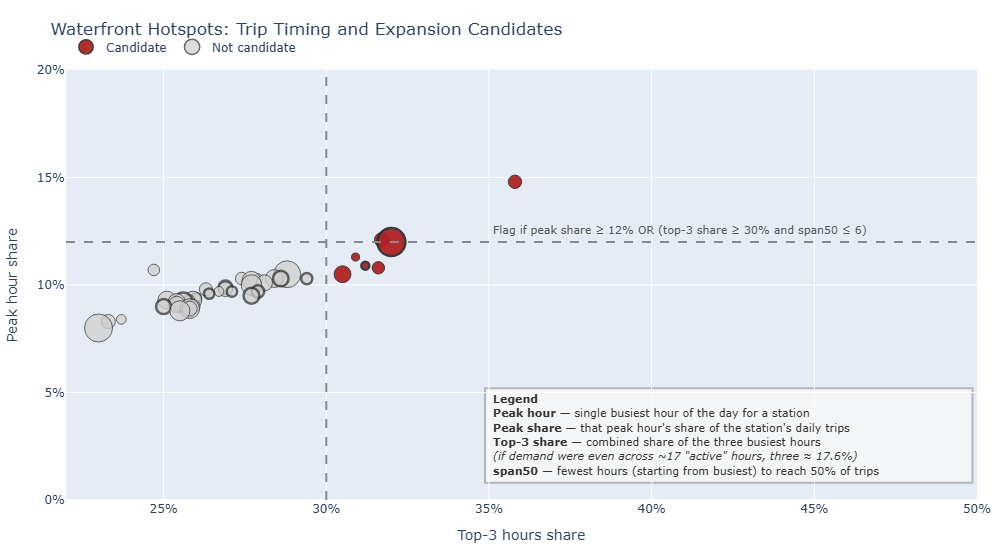

In [17]:
import numpy as np, pandas as pd, plotly.graph_objects as go

# --- Source data ---
df = hotspot_hourly_summary.copy()

# --- Candidate rule ---
cand_mask = (df["peak_share"] >= 0.12) | ((df["top3_share"] >= 0.30) & (df["span50_hours"] <= 6))
df["is_candidate"] = np.where(cand_mask, "Candidate", "Not candidate")
line_w = np.where(df["span50_hours"] <= 6, 2.5, 1.0)

# --- Figure ---
fig = go.Figure()
for group, color in [("Candidate", "#B22222"), ("Not candidate", "#CFCFCF")]:
    sub = df[df["is_candidate"] == group]
    size = np.clip(sub["total_trips"] / sub["total_trips"].max() * 28, 8, 28)
    fig.add_scatter(
        x=sub["top3_share"], y=sub["peak_share"], mode="markers",
        marker=dict(size=size, color=color, line=dict(color="#333", width=line_w[sub.index]),
                    opacity=0.95 if group=="Candidate" else 0.75),
        name=group,
        hovertemplate=(
            "<b>%{customdata[0]}</b><br>"
            "Peak hr: %{customdata[1]}:00<br>"
            "Peak share: %{y:.1%}<br>"
            "Top-3 share: %{x:.1%}<br>"
            "span50: %{customdata[2]} hrs<br>"
            "Trips: %{customdata[3]:,}<extra></extra>"
        ),
        customdata=np.stack([sub["station_name"], sub["peak_hour"],
                             sub["span50_hours"], sub["total_trips"]], axis=1)
    )

# Threshold rules
fig.add_hline(y=0.12, line_dash="dash", line_color="#888")
fig.add_vline(x=0.30, line_dash="dash", line_color="#888")

# --- Stable axes so the "center" never jumps ---
fig.update_layout(
    title="Waterfront Hotspots: Trip Timing and Expansion Candidates",
    xaxis=dict(title="Top-3 hours share", tickformat=".0%", range=[0.22, 0.50]),
    yaxis=dict(title="Peak hour share", tickformat=".0%", range=[0.00, 0.20]),
    legend=dict(orientation="h", yanchor="bottom", y=1.02, x=0),
    height=560, margin=dict(l=60, r=20, t=70, b=60),
    hoverlabel=dict(bgcolor="white")
)

# --- Rule note: positioned just above the 12% line and moved further right ---
fig.add_annotation(
    xref="paper", yref="paper", x=0.88, y=0.63, showarrow=False,
    text="Flag if peak share ≥ 12% OR (top-3 share ≥ 30% and span50 ≤ 6)",
    font=dict(size=11, color="#555"), align="left"
)

# --- Legend box (even wider and more to the left) + text fully inside ---
# box (bottom-right, expanded further)
fig.add_shape(
    type="rect", xref="paper", yref="paper",
    x0=0.46, x1=0.995, y0=0.04, y1=0.26,
    line=dict(color="rgba(50,50,50,0.30)"),
    fillcolor="rgba(245,245,245,0.92)",
    layer="below"
)

# text inside the box (top-left corner of the expanded box)
fig.add_annotation(
    xref="paper", yref="paper", x=0.465, y=0.255,
    xanchor="left", yanchor="top", showarrow=False, align="left",
   text=(
       "<b>Legend</b><br>" +
       "<b>Peak hour</b> — single busiest hour of the day for a station<br>" +
       "<b>Peak share</b> — that peak hour's share of the station's daily trips<br>" +
       "<b>Top-3 share</b> — combined share of the three busiest hours<br>" +
       "<i>(if demand were even across ~17 \"active\" hours, three ≈ 17.6%)</i><br>" +
       "<b>span50</b> — fewest hours (starting from busiest) to reach 50% of trips"
),
    font=dict(size=11, color="#333")
)

fig.write_html(r"C:\Users\magia\OneDrive\Desktop\NY_Citi_Bike\4.Visualizations\waterfront_expansion.html")

fig.show()

In [18]:
print(f"Total unique stations: {len(stations_u)}")
print(f"Waterfront stations: {stations_flagged['near_water'].sum()}")

Total unique stations: 1842
Waterfront stations: 273
